In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
import scipy.integrate as integrate
from scipy.linalg import ishermitian

In [12]:
def nfib(n):
    def fib(k):
        if k == 0:
            return (0, 1)
        else:
            a, b = fib(k >> 1)
            c = a * ((b << 1) - a)
            d = a * a + b * b
            if k & 1:
                return (d, c + d)
            else:
                return (c, d)
    return fib(n)[0]

w2 = 0.1
fib = 10
p = nfib(fib)
q = nfib(fib-1)
w1 = (p/q)*w2
w = w2/q
latsize = 1
phi1 = 0
phi2 = 0
m = 1

In [7]:
sigmax = np.matrix([[0, 1],[1, 0]], dtype=complex)
sigmay = np.matrix([[0, -1j],[1j, 0]], dtype=complex)
sigmaz = np.matrix([[1, 0j],[0, -1]], dtype=complex)

def temporalBHZ(w1, phi1, w2, phi2, m, t):
    return np.sin(w1*t+phi1)*sigmax + np.sin(w2*t+phi2)*sigmay + (m - np.cos(w1*t+phi1) - np.cos(w2*t+phi2))*sigmaz

def dh1t(w1, phi1, t):
    return w1*(np.sin(w1*t+phi1+t)*sigmaz +np.cos(w1*t+phi1)*sigmax)
def dh2t(w2, phi2, t):
    return w2*(np.sin(w2*t+phi2+t)*sigmaz +np.cos(w2*t+phi2)*sigmay)    

We use the evolution operator caluclated using the dyson series, and the derivatives of hamiltonian as calculated above. 

In [21]:
def simpson1(f, a, b):
    res = f(a) + f(b) + 4*f((a+b)/2)
    return (b-a)*res/6
def simpson2(g, a, b, c, d): # a and b are x limits. c and d are y limits
    hx, hy = b - a, d - c
    t1 = g(a, c) + g(b, c) + g(a, d) + g(b, d)
    t2 = g((a+b)/2, c) + g((a+b)/2, d) + g(a, (c+d)/2) + g(b, (c+d)/2)
    t3 = g((a+b)/2, (c+d)/2)
    return hx*hy*(t1 + 4*t2 + 16*t3)/36 
    
h1 = lambda t: temporalBHZ(w1, phi1, w2, phi2, m, t)
h2 = lambda t1, t2: temporalBHZ(w1, phi1, w2, phi2, m, t1) @ temporalBHZ(w1, phi1, w2, phi2, m, t2)
h0 = np.matrix(np.eye(2, dtype=complex))

def U(t):
    t1 = simpson1(h1, 0, t)
    t2 = simpson2(h2, 0, t, 0, t/3)
    return h0 - (1j)*t1 - t2

In [109]:
def work1(w1, phi1, ti, tf):
    def op(w1, phi1, t):
        return U(t).H @ dh1t(w1, phi1, t) @ U(t)
    res = np.zeros((2,2), dtype=complex)
    res[0,0] = integrate.quad(lambda t: np.real(op(w1, phi1, t)[0,0]), ti, tf)[0] + integrate.quad(lambda t: np.imag(op(w1, phi1, t)[0,0]), ti, tf)[0]
    res[0,1] = integrate.quad(lambda t: np.real(op(w1, phi1, t)[0,1]), ti, tf)[0] + integrate.quad(lambda t: np.imag(op(w1, phi1, t)[0,1]), ti, tf)[0]
    res[1,0] = integrate.quad(lambda t: np.real(op(w1, phi1, t)[1,0]), ti, tf)[0] + integrate.quad(lambda t: np.imag(op(w1, phi1, t)[1,0]), ti, tf)[0]
    res[1,1] = integrate.quad(lambda t: np.real(op(w1, phi1, t)[1,1]), ti, tf)[0] + integrate.quad(lambda t: np.imag(op(w1, phi1, t)[1,1]), ti, tf)[0]
    return np.matrix(res)
    
def work2(w2, phi2, ti, tf):
    def op(w2, phi2, t):
        return U(t).H @ dh2t(w2, phi2, t) @ U(t)
    res = np.zeros((2,2), dtype=complex)
    res[0,0] = integrate.quad(lambda t: np.real(op(w2, phi2, t)[0,0]), ti, tf)[0] + integrate.quad(lambda t: np.imag(op(w2, phi2, t)[0,0]), ti, tf)[0]
    res[0,1] = integrate.quad(lambda t: np.real(op(w2, phi2, t)[0,1]), ti, tf)[0] + integrate.quad(lambda t: np.imag(op(w2, phi2, t)[0,1]), ti, tf)[0]
    res[1,0] = integrate.quad(lambda t: np.real(op(w2, phi2, t)[1,0]), ti, tf)[0] + integrate.quad(lambda t: np.imag(op(w2, phi2, t)[1,0]), ti, tf)[0]
    res[1,1] = integrate.quad(lambda t: np.real(op(w2, phi2, t)[1,1]), ti, tf)[0] + integrate.quad(lambda t: np.imag(op(w2, phi2, t)[1,1]), ti, tf)[0]
    return np.matrix(res)

In [108]:
cycles = 3
tvals = np.arange(0, cycles*2*np.pi/w1,0.1)
psi0 = np.matrix([[1.+0.j],[0.+0.j]])
p1, p2 = [], []
for i in range(len(tvals)-1):
    p1.append((psi0.H @work1(w1, phi1, tvals[i], tvals[i+1])@psi0).item())
    p2.append((psi0.H @work2(w2, phi2, tvals[i], tvals[i+1])@psi0).item())

In [116]:
from multiprocessing import Pool

# psi0 must be defined at top level
psi0 = np.matrix([[1.+0.j],[0.+0.j]])

def compute_p1(pair):
    t0, t1 = pair
    return (psi0.H @ work1(w1, phi1, t0, t1) @ psi0).item()

def compute_p2(pair):
    t0, t1 = pair
    return (psi0.H @ work2(w2, phi2, t0, t1) @ psi0).item()

if __name__ == "__main__":
    cycles = 3
    tvals = np.arange(0, cycles*2*np.pi/w1, 0.1)
    pairs = [(tvals[i], tvals[i+1]) for i in range(len(tvals)-1)]

    with Pool(processes=6) as pool:
        p1 = pool.map(compute_p1, pairs)
        p2 = pool.map(compute_p2, pairs)


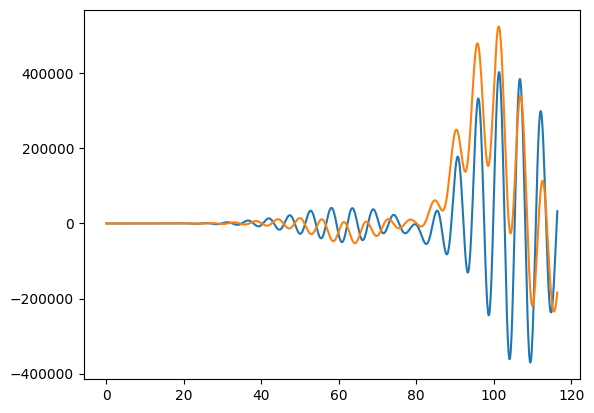

In [117]:
plt.plot(tvals[:len(tvals)-1], np.real(p1))
plt.plot(tvals[:len(tvals)-1], np.real(p2))
plt.show()